### 【問題1】train_test_splitのスクラッチ
スクラッチの練習として、scikit-learnのtrain_test_splitを自作してみます。以下の雛形をベースとして関数を完成させてください。

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

なお、作成した関数がscikit-learnのtrain_test_splitと同じ動作をしているか必ず確認をするようにしましょう。

In [163]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

def scratch_train_test_split(X, y, train_size=0.8,):

    #trainデータへ分割するサイズ：X_train_sizeを計算。 
    size_X = X.shape
    X_train_size = size_X[0] * train_size
    X_train_size = int(X_train_size) 

    #X,yを組みにして行をシャッフルする。
    y = y.flatten()  #y.shapeが(数値,1)で入力される場合もあるため平坦化する。
    Xy = np.concatenate((X, y[:, np.newaxis]), axis=1)
    np.random.seed(100)
    np.random.shuffle(Xy)
      
    #X,yの各train, testデータへ分割する。
    Xy_train, Xy_test = np.split(Xy, [X_train_size], 0)
    X_train, y_train = np.split(Xy_train, [size_X[1]],1)
    X_test, y_test = np.split(Xy_test, [size_X[1]],1)

   #要求仕様に合わせ、yの次元を1次元に変換する。
    y_train = y_train.flatten() 
    y_test = y_test.flatten()
  
    return X_train, X_test, y_train, y_test

#動作確認用のndarray　Xのサイズ:(10,2), Yのサイズ:(10,)とした。
X = np.array([['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']]).T
y = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

#動作確認（スクラッチ）
X_train, X_test, y_train, y_test = scratch_train_test_split(X,y)
print('動作確認（スクラッチ)')
print('X_train size {}'.format(X_train.shape), '\n', X_train, '\n')
print('X_test  size {}'.format(X_test.shape), '\n', X_test, '\n')
print('y_train size {}'.format(y_train.shape), '\n', y_train, '\n')
print('y_test size {}'.format(y_test.shape), '\n',  y_test, '\n')

#動作確認（import）
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print('動作確認（import)')
print('X_train size {}'.format(X_train.shape), '\n', X_train, '\n')
print('X_test  size {}'.format(X_test.shape), '\n', X_test, '\n')
print('y_train size {}'.format(y_train.shape), '\n', y_train, '\n')
print('y_test size {}'.format(y_test.shape), '\n',  y_test, '\n')

動作確認（スクラッチ)
X_train size (8, 2) 
 [['h' 'h']
 ['g' 'g']
 ['b' 'b']
 ['f' 'f']
 ['e' 'e']
 ['c' 'c']
 ['a' 'a']
 ['d' 'd']] 

X_test  size (2, 2) 
 [['j' 'j']
 ['i' 'i']] 

y_train size (8,) 
 ['H' 'G' 'B' 'F' 'E' 'C' 'A' 'D'] 

y_test size (2,) 
 ['J' 'I'] 

動作確認（import)
X_train size (8, 2) 
 [['f' 'f']
 ['d' 'd']
 ['e' 'e']
 ['g' 'g']
 ['a' 'a']
 ['b' 'b']
 ['j' 'j']
 ['c' 'c']] 

X_test  size (2, 2) 
 [['h' 'h']
 ['i' 'i']] 

y_train size (8,) 
 ['F' 'D' 'E' 'G' 'A' 'B' 'J' 'C'] 

y_test size (2,) 
 ['H' 'I'] 



## 【問題2】 分類問題を解くコードの作成

上記3種類の手法で3種類のデータセットを学習・推定するコードを作成してください。

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#分析データの取得
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(iris_dataset.target, columns=["Species"])
df = pd.concat([X, y], axis=1)
X = df.query("Species == 1 | Species == 2").loc[:,["sepal_length", "sepal_width", "petal_length", "petal_width"]]
X = X.values
y = df.query("Species == 1 | Species == 2").loc[:,"Species"]
y = y.values

#train, testデータへの分割
X_train, X_test, y_train, y_test = scratch_train_test_split(X,y)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

#機械学習（ロジスティック回帰）
clf = SGDClassifier(loss="log")
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)
print("ロジスティック回帰")
print(y_pred)
print(y_test)

#機械学習（SVC）
svc = SVC()
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)
print("SVC")
print(y_pred)
print(y_test)

#機械学習（決定木）
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train_transformed, y_train)
y_pred = tree.predict(X_test_transformed)
print("決定木")
print(y_pred)
print(y_test)



ロジスティック回帰
[2. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1.]
[1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1.]
SVC
[2. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1.]
[1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1.]
決定木
[2. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1.]
[1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 1. 1.]


※特徴量が４と多いため、可視化は実施していない。

### シンプルデータセット1作成コード

ロジスティック回帰


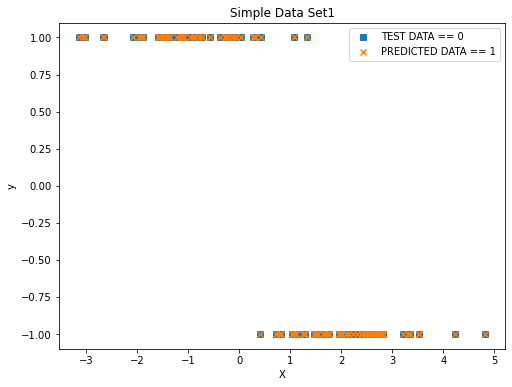

SVC


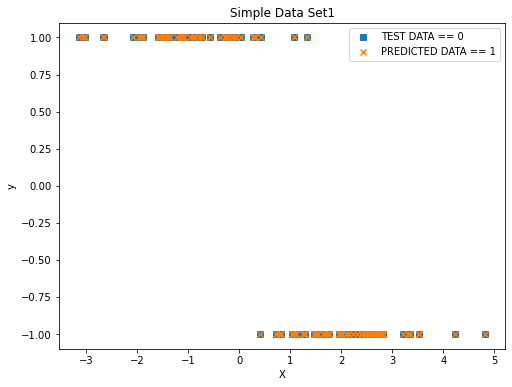

決定木


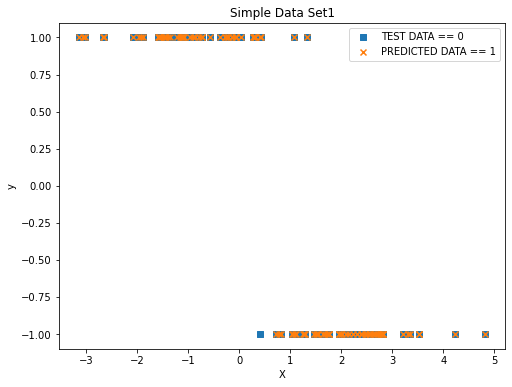

In [158]:
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
#print(f0.shape) → (250, 2)
#print(f1.shape) → (250, 2)
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int) #f0に1, f1に-1を対応させている。
random_index = np.random.permutation(np.arange(n_samples))
#print(random_index) 0から500まで数値がランダムで並んでいる
X = X[random_index] #: X,yをセットにして値をランダムに並べ直す
y = y[random_index]
#print(X.shape) → (500, 2)
#print(y.shape) → (500, )

#train, testデータへの分割
X_train, X_test, y_train, y_test = scratch_train_test_split(X,y)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

for i in range(3):
    #機械学習３パターン
    if i==0:
        print("ロジスティック回帰")
        clf = SGDClassifier(loss="log")
        clf.fit(X_train_transformed, y_train)
        y_pred = clf.predict(X_test_transformed)
    elif i==1:
        print("SVC")
        svc = SVC()
        svc.fit(X_train_transformed, y_train)
        y_pred = svc.predict(X_test_transformed)
    else:
        print("決定木")
        tree = DecisionTreeClassifier(random_state=0)
        tree.fit(X_train_transformed, y_train)
        y_pred = tree.predict(X_test_transformed)

    #グラフ描画 
    fig = plt.figure(figsize=(8, 6), dpi=72)
    plt.scatter(X_test[:,0], y_test,  marker='s', label='TEST DATA == 0')
    plt.scatter(X_test[:,0], y_pred, marker='x', label='PREDICTED DATA == 1')
    plt.xlabel("X") 
    plt.ylabel("y")
    plt.title("Simple Data Set1")
    plt.legend()
    plt.show()


### シンプルデータセット2作成コード

ロジスティック回帰


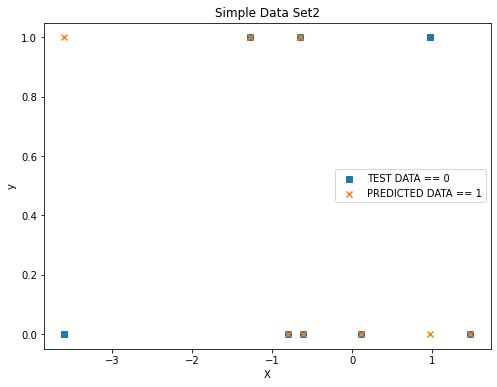

SVC


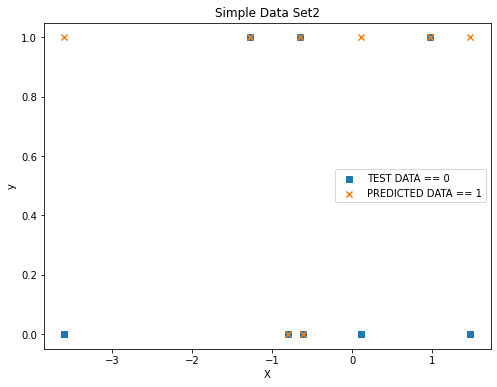

決定木


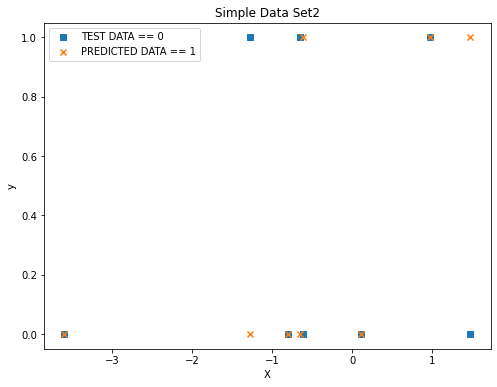

In [160]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#print(X.shape) #→(40, 2)
#print(y.shape)　#→(40,)

#train, testデータへの分割
X_train, X_test, y_train, y_test = scratch_train_test_split(X,y)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

for i in range(3):
    #機械学習３パターン
    if i==0:
        print("ロジスティック回帰")
        clf = SGDClassifier(loss="log")
        clf.fit(X_train_transformed, y_train)
        y_pred = clf.predict(X_test_transformed)
    elif i==1:
        print("SVC")
        svc = SVC()
        svc.fit(X_train_transformed, y_train)
        y_pred = svc.predict(X_test_transformed)
    else:
        print("決定木")
        tree = DecisionTreeClassifier(random_state=0)
        tree.fit(X_train_transformed, y_train)
        y_pred = tree.predict(X_test_transformed)

    #グラフ描画 
    fig = plt.figure(figsize=(8, 6), dpi=72)
    plt.scatter(X_test[:,0], y_test,  marker='s', label='TEST DATA == 0')
    plt.scatter(X_test[:,0], y_pred, marker='x', label='PREDICTED DATA == 1')
    plt.xlabel("X") 
    plt.ylabel("y")
    plt.title("Simple Data Set2")
    plt.legend()
    plt.show()


### 【問題3】 回帰問題を解くコードの作成
線形回帰でHouse Pricesデータセットを学習・推定するコードを作成してください。

(1168,)


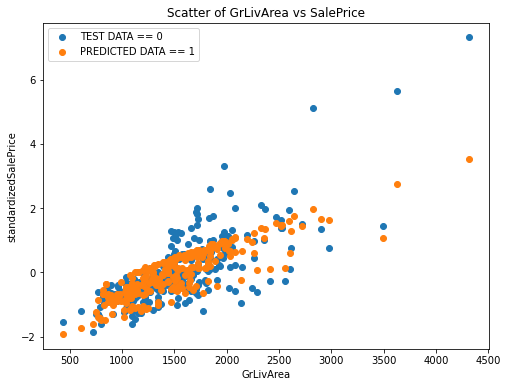

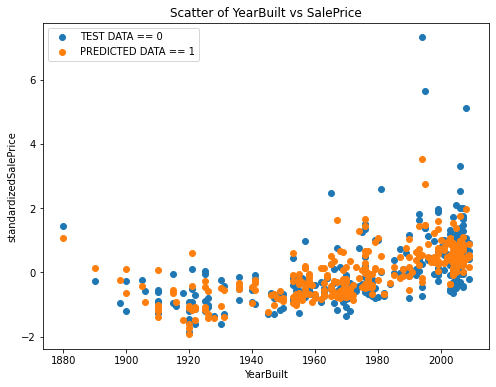

In [179]:
from sklearn.linear_model import SGDRegressor

#データの読込
df = pd.read_csv("train.csv")
X = df.loc[:,["GrLivArea", "YearBuilt"]].values
y = df.loc[:,["SalePrice"]].values
#print(X.shape) → (1460,2)
#print(y.shape) → (1460,1)

#train, testデータへの分割
X_train, X_test, y_train, y_test = scratch_train_test_split(X,y)

#標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

scaler.fit(y_train.reshape(-1,1))
y_train_transformed = scaler.transform(y_train.reshape(-1,1))
y_test_transformed = scaler.transform(y_test.reshape(-1,1))

#機械学習
reg = SGDRegressor()
reg.fit(X_train_transformed, y_train_transformed.flatten())
y_pred = reg.predict(X_test_transformed)

#グラフ描画 GrLivArea
fig = plt.figure(figsize=(8, 6), dpi=72)
plt.scatter(X_test[:,0], y_test_transformed, label='TEST DATA == 0')
plt.scatter(X_test[:,0], y_pred, label='PREDICTED DATA == 1')
plt.xlabel("GrLivArea")
plt.ylabel("standardizedSalePrice")
plt.title("Scatter of GrLivArea vs SalePrice")
plt.legend()
plt.show()

#グラフ描画 YearBuilt
fig = plt.figure(figsize=(8, 6), dpi=72)
plt.scatter(X_test[:,1], y_test_transformed, label='TEST DATA == 0')
plt.scatter(X_test[:,1], y_pred, label='PREDICTED DATA == 1')
plt.xlabel("YearBuilt")
plt.ylabel("standardizedSalePrice")
plt.title("Scatter of YearBuilt vs SalePrice")
plt.legend()
plt.show()